In [ ]:
pip install qiskit

In [ ]:
import numpy as np
import warnings
from tqdm.auto import tqdm
import qiskit as qk
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer, assemble
from qiskit.visualization import circuit_drawer, plot_histogram, plot_state_qsphere
from qiskit import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pi = np.pi
%matplotlib inline

# Functions

## Measurement Functions

In [ ]:
#some helper functions

#statevector, qsphere
def execute_circuit_sv(quantum_circuit):
  statevector_simulator = Aer.get_backend('statevector_simulator')
  result = execute(quantum_circuit, statevector_simulator).result()
  statevector_results = result.get_statevector(quantum_circuit)
  circuit_diagram = quantum_circuit.draw()
  q_sphere = plot_state_qsphere(statevector_results)
  return statevector_results, circuit_diagram, q_sphere

#counts, histogram
def execute_circuit(quantum_circuit,shot):
  simulator = Aer.get_backend('qasm_simulator')
  result = execute(quantum_circuit, simulator, shots=shot).result()
  results = result.get_counts(quantum_circuit)
  circuit_diagram = quantum_circuit.draw()
  histogram = plot_histogram(results)
  return results, circuit_diagram, histogram

def execute_QC(quantum_circuit,shot):
  simulator = Aer.get_backend('qasm_simulator')
  result = execute(quantum_circuit, backend=simulator, shots=shot).result().get_counts()
  return result

#X-basis
def X_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    return qc

#Y-basis
def Y_measurement(qc, qubit, cbit):
   """Measure 'qubit' in the Y-basis, and store the result in 'cbit'"""
   qc.sdg(qubit)
   qc.h(qubit)
   qc.measure(qubit, cbit)
   return qc

def ZZ_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

def XX_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

def YY_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.sdg(qubit1)
  qc.sdg(qubit2)
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

def Measure(qc, basis, qubit1,qubit2,cbit1,cbit2):
  if basis == 'Z':
    qc.measure([0,0])
  elif basis == 'Y':
    Y_measurement(qc,qubit1,cbit1)
  elif basis == 'X':
    X_measurement(qc,qubit1,cbit1)
  elif basis == 'ZZ':
    ZZ_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'YY':
    YY_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'XX':
    XX_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  return qc

## Gate and Quantum Circuit Functions

In [ ]:
def SWAP(var):
  
  a = var[0]
  b = var[1]
  y = var[2]
  theta = pi/2 - 2*y 
  phi = 2*a-pi/2
  lamda = pi/2 -2*b
  qc = QuantumCircuit(2)
  qc.rz(-pi/2,1)
  qc.cx(1,0)
  qc.rz(theta,0)
  qc.ry(phi,1)
  qc.cx(0,1)
  qc.ry(lamda,1)
  qc.cx(1,0)
  qc.rz(pi/2,0)
  swap = qc.to_gate()

  return swap

def Unitary(quantum_circuit,y,nqbits):
  #rz(-pi/2)
  for idx in range(nqbits):
    quantum_circuit.rz(-pi/2,idx)

  quantum_circuit.barrier()
  
  #odd
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP(y), [idx,idx+1])
  #even
  for idx in range(nqbits):
    if idx%2 == 1:
      continue
    else:
      if idx == nqbits:
        break
      else:
        quantum_circuit.append(SWAP(y), [idx,idx+1])
  #odd
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP(y), [idx,idx+1])

  quantum_circuit.barrier()
  #rz(pi/2)
  for idx in range(nqbits):
    quantum_circuit.rz(pi/2,idx)
  return quantum_circuit

def Initial_State(quantum_circuit,IS,nqbits):
  if IS == 'odd':
    for idx in range(nqbits):
      if idx%2 == 0: #skips even numbered qubits
        continue
      else:
        quantum_circuit.x(idx)
  elif IS =='even':
    for idx in range(nqbits):
       if idx%2 == 1: #skips odd numbered qubits
        continue
    else:
      quantum_circuit.x(idx)
  return quantum_circuit

def Trotter(quantum_circuit, numTstep, nqbits, y):
  for i in range(numTstep):
      Unitary(quantum_circuit, y, nqbits)
  return quantum_circuit

def Quntum_Circuit(IS,nqbits,ncbits, y, numTstep):
     Qreg = QuantumRegister(nqbits)
     Creg = ClassicalRegister(ncbits)
     QC = QuantumCircuit(Qreg,Creg)
     Initial_State(QC,IS,nqbits)
     QC.barrier()
     Trotter(QC,numTstep,nqbits,y)
     return QC

def Results(IS,nqbits,ncbits,numTstep,basis,var,shots):
  qc = Quntum_Circuit(IS,nqbits,ncbits,var,numTstep)
  prob00 = []
  prob01 = []
  prob10 = []
  prob11 = []
  for measure_circuit in basis:
    QC = qc + Measure(qc,measure_circuit,0,1,0,1)
    counts = execute_QC(QC,shots)
    probs = {}
    for output in ['00','01', '10', '11']:
      if output in counts:
        probs[output] = counts[output]/shots
      else:
        probs[output] = 0
    prob00.append(probs['00'])
    prob10.append(probs['01'])
    prob01.append(probs['10'])
    prob11.append(probs['11'])
  return prob00, prob01, prob10, prob11

# Results

## Static Gamma

### ZZ Basis

#### Single Trotter Step

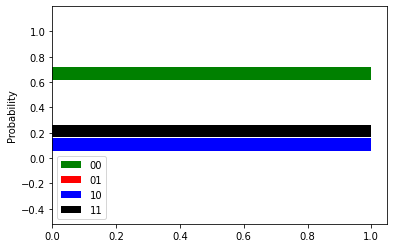

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 1
basis = ['ZZ']
var = np.array([pi/12,pi/12,-pi/4])
S00,S01,S10,S11 = Results('odd',qbit,cbit,trotter,basis,var,shots)
plt.hist(S00, label="00", color='g', orientation='horizontal')
plt.hist(S01, label="01", color='r',orientation='horizontal')
plt.hist(S10, label="10", color='b', orientation='horizontal')
plt.hist(S11, label="11", color='k',orientation='horizontal')
plt.ylabel('Probability')
plt.legend()

#### Two Trotter Steps

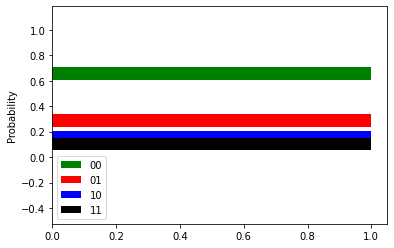

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 2
basis = ['ZZ']
var = np.array([pi/12,pi/12,-pi/4])
S200,S201,S210,S211 = Results('odd',qbit,cbit,trotter,basis,var,shots)
plt.hist(S200, label="00", color='g', orientation='horizontal')
plt.hist(S201, label="01", color='r',orientation='horizontal')
plt.hist(S210, label="10", color='b', orientation='horizontal')
plt.hist(S211, label="11", color='k',orientation='horizontal')
plt.ylabel('Probability')
plt.legend()

#### Three Trotter Step

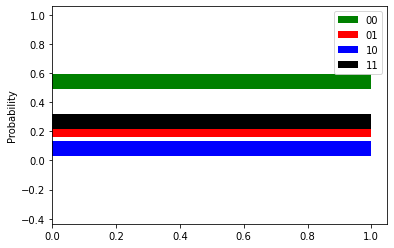

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 3
basis = ['ZZ']
var = np.array([pi/12,pi/12,-pi/4])
S300,S301,S310,S311 = Results('odd',qbit,cbit,trotter,basis,var,shots)
plt.hist(S300, label="00", color='g', orientation='horizontal')
plt.hist(S301, label="01", color='r',orientation='horizontal')
plt.hist(S310, label="10", color='b', orientation='horizontal')
plt.hist(S311, label="11", color='k',orientation='horizontal')
plt.ylabel('Probability')
plt.legend()

#### Four Trotter Steps

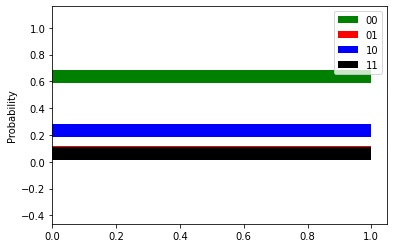

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 4
basis = ['ZZ']
var = np.array([pi/12,pi/12,-pi/4])
S400,S401,S410,S411 = Results('odd',qbit,cbit,trotter,basis,var,shots)
plt.hist(S400, label="00", color='g', orientation='horizontal')
plt.hist(S401, label="01", color='r',orientation='horizontal')
plt.hist(S410, label="10", color='b', orientation='horizontal')
plt.hist(S411, label="11", color='k',orientation='horizontal')
plt.ylabel('Probability')
plt.legend()

#### Five Trotter Step

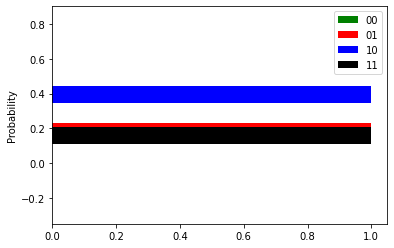

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 5
basis = ['ZZ']
var = np.array([pi/12,pi/12,-pi/4])
S500,S501,S510,S511 = Results('odd',qbit,cbit,trotter,basis,var,shots)
plt.hist(S500, label="00", color='g', orientation='horizontal')
plt.hist(S501, label="01", color='r',orientation='horizontal')
plt.hist(S510, label="10", color='b', orientation='horizontal')
plt.hist(S511, label="11", color='k',orientation='horizontal')
plt.ylabel('Probability')
plt.legend()

#### Combining Trotter Steps

Text(0, 0.5, 'Probability')

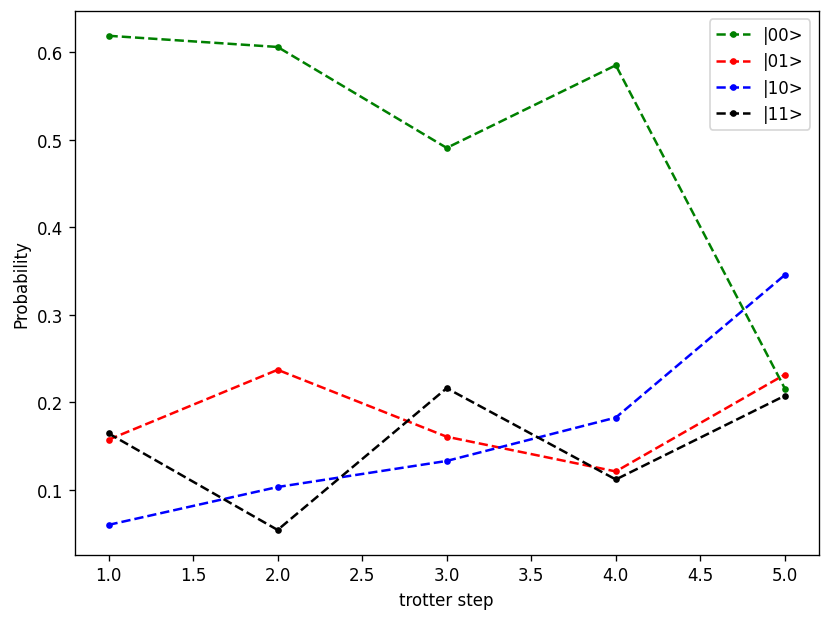

In [ ]:
TrotterStep = [1,2,3,4,5]
St00 =  np.array([S00,S200,S300,S400,S500])
St01 =  np.array([S01,S201,S301,S401,S501])
St10 =  np.array([S10,S210,S310,S410,S510])
St11 =  np.array([S11,S211,S311,S411,S511])

figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(TrotterStep, St00,'g.--',label="|00>")
plt.plot(TrotterStep, St01,'r.--',label="|01>")
plt.plot(TrotterStep, St10,'b.--',label="|10>")
plt.plot(TrotterStep, St11,'k.--',label="|11>")
plt.legend()
plt.xlabel('trotter step')
plt.ylabel('Probability')

### XX+YY+ZZ Basis

#### Single Trotter Step

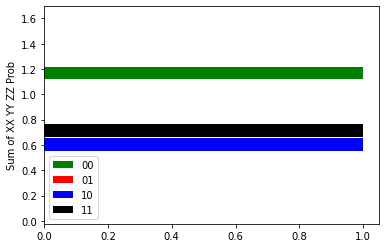

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 1
basis = ['ZZ','XX','YY']
var = np.array([pi/12,pi/12,-pi/4])
XYY_ST1 = Results('odd',qbit,cbit,trotter,basis,var,shots)
XYZ_S00 = np.sum(XYY_ST1[0])
XYZ_S01 = np.sum(XYY_ST1[1])
XYZ_S10 = np.sum(XYY_ST1[2])
XYZ_S11 = np.sum(XYY_ST1[3])
plt.hist(XYZ_S00, label="00", color='g', orientation='horizontal')
plt.hist(XYZ_S01, label="01", color='r',orientation='horizontal')
plt.hist(XYZ_S10, label="10", color='b', orientation='horizontal')
plt.hist(XYZ_S11, label="11", color='k',orientation='horizontal')
plt.ylabel('Sum of XX YY ZZ Prob')
plt.legend()

#### Two Trotter Steps

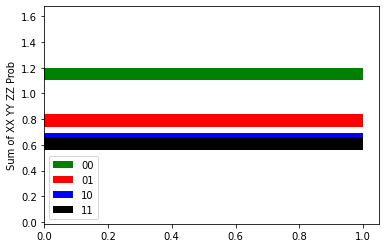

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 2
basis = ['ZZ','XX','YY']
var = np.array([pi/12,pi/12,-pi/4])
XYY_ST2 = Results('odd',qbit,cbit,trotter,basis,var,shots)
XYZ_S200 = np.sum(XYY_ST2[0])
XYZ_S201 = np.sum(XYY_ST2[1])
XYZ_S210 = np.sum(XYY_ST2[2])
XYZ_S211 = np.sum(XYY_ST2[3])
plt.hist(XYZ_S200, label="00", color='g', orientation='horizontal')
plt.hist(XYZ_S201, label="01", color='r',orientation='horizontal')
plt.hist(XYZ_S210, label="10", color='b', orientation='horizontal')
plt.hist(XYZ_S211, label="11", color='k',orientation='horizontal')
plt.ylabel('Sum of XX YY ZZ Prob')
plt.legend()

#### Three Trotter Step

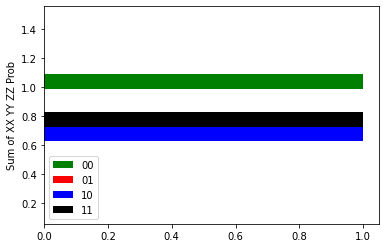

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 3
basis = ['ZZ','XX','YY']
var = np.array([pi/12,pi/12,-pi/4])
XYY_ST3 = Results('odd',qbit,cbit,trotter,basis,var,shots)
XYZ_S300 = np.sum(XYY_ST3[0])
XYZ_S301 = np.sum(XYY_ST3[1])
XYZ_S310 = np.sum(XYY_ST3[2])
XYZ_S311 = np.sum(XYY_ST3[3])
plt.hist(XYZ_S300, label="00", color='g', orientation='horizontal')
plt.hist(XYZ_S301, label="01", color='r',orientation='horizontal')
plt.hist(XYZ_S310, label="10", color='b', orientation='horizontal')
plt.hist(XYZ_S311, label="11", color='k',orientation='horizontal')
plt.ylabel('Sum of XX YY ZZ Prob')
plt.legend()

#### Four Trotter Steps

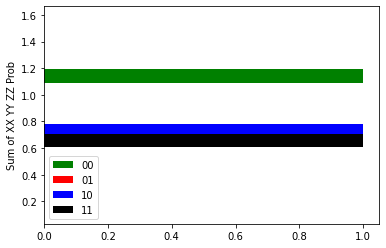

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 4
basis = ['ZZ','XX','YY']
var = np.array([pi/12,pi/12,-pi/4])
XYY_ST4 = Results('odd',qbit,cbit,trotter,basis,var,shots)
XYZ_S400 = np.sum(XYY_ST4[0])
XYZ_S401 = np.sum(XYY_ST4[1])
XYZ_S410 = np.sum(XYY_ST4[2])
XYZ_S411 = np.sum(XYY_ST4[3])
plt.hist(XYZ_S400, label="00", color='g', orientation='horizontal')
plt.hist(XYZ_S401, label="01", color='r',orientation='horizontal')
plt.hist(XYZ_S410, label="10", color='b', orientation='horizontal')
plt.hist(XYZ_S411, label="11", color='k',orientation='horizontal')
plt.ylabel('Sum of XX YY ZZ Prob')
plt.legend()

#### Five Trotter Step

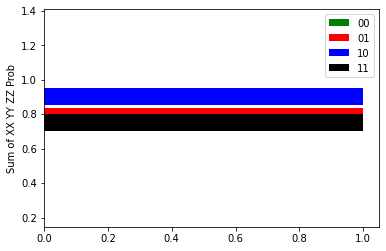

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 5
basis = ['ZZ','XX','YY']
var = np.array([pi/12,pi/12,-pi/4])
XYY_ST5 = Results('odd',qbit,cbit,trotter,basis,var,shots)
XYZ_S500 = np.sum(XYY_ST5[0])
XYZ_S501 = np.sum(XYY_ST5[1])
XYZ_S510 = np.sum(XYY_ST5[2])
XYZ_S511 = np.sum(XYY_ST5[3])
plt.hist(XYZ_S500, label="00", color='g', orientation='horizontal')
plt.hist(XYZ_S501, label="01", color='r',orientation='horizontal')
plt.hist(XYZ_S510, label="10", color='b', orientation='horizontal')
plt.hist(XYZ_S511, label="11", color='k',orientation='horizontal')
plt.ylabel('Sum of XX YY ZZ Prob')
plt.legend()

#### Combining Trotter Steps

Text(0, 0.5, 'Sum of XX YY ZZ Prob')

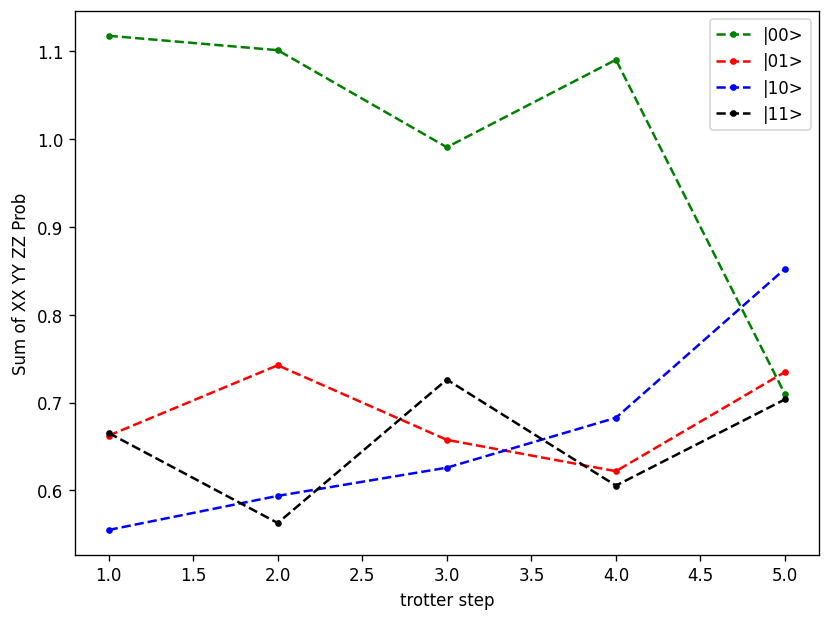

In [ ]:
TrotterStep = [1,2,3,4,5]
XYZ_St00 =  np.array([XYZ_S00,XYZ_S200,XYZ_S300,XYZ_S400,XYZ_S500])
XYZ_St01 =  np.array([XYZ_S01,XYZ_S201,XYZ_S301,XYZ_S401,XYZ_S501])
XYZ_St10 =  np.array([XYZ_S10,XYZ_S210,XYZ_S310,XYZ_S410,XYZ_S510])
XYZ_St11 =  np.array([XYZ_S11,XYZ_S211,XYZ_S311,XYZ_S411,XYZ_S511])

figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(TrotterStep, XYZ_St00,'g.--',label="|00>")
plt.plot(TrotterStep, XYZ_St01,'r.--',label="|01>")
plt.plot(TrotterStep, XYZ_St10,'b.--',label="|10>")
plt.plot(TrotterStep, XYZ_St11,'k.--',label="|11>")
plt.legend()
plt.xlabel('trotter step')
plt.ylabel('Sum of XX YY ZZ Prob')

## Varying Gamma

### ZZ Basis

#### Single Trotter Step

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 1
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ']
state_00 = []
state_01 = []
state_10 = []
state_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  state_00.append(State[0])
  state_01.append(State[1])
  state_10.append(State[2])
  state_11.append(State[3])

Text(0, 0.5, 'probability')

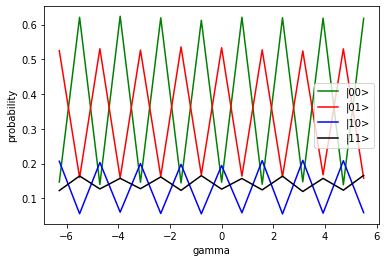

In [ ]:
plt.plot(gamma,state_00,color='g',label='|00>')
plt.plot(gamma,state_01, color='r',label='|01>')
plt.plot(gamma,state_10,color='b',label='|10>')
plt.plot(gamma,state_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('probability')

#### Two Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 2
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ']
state2_00 = []
state2_01 = []
state2_10 = []
state2_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  state2_00.append(State[0])
  state2_01.append(State[1])
  state2_10.append(State[2])
  state2_11.append(State[3])

Text(0, 0.5, 'probability')

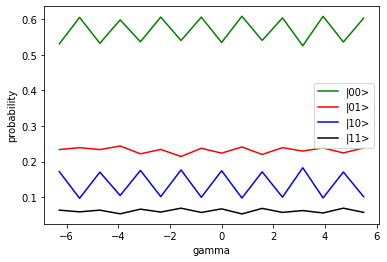

In [ ]:
plt.plot(gamma,state2_00,color='g',label='|00>')
plt.plot(gamma,state2_01, color='r',label='|01>')
plt.plot(gamma,state2_10,color='b',label='|10>')
plt.plot(gamma,state2_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('probability')

#### Three Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 3
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ']
state3_00 = []
state3_01 = []
state3_10 = []
state3_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  state3_00.append(State[0])
  state3_01.append(State[1])
  state3_10.append(State[2])
  state3_11.append(State[3])

Text(0, 0.5, 'probability')

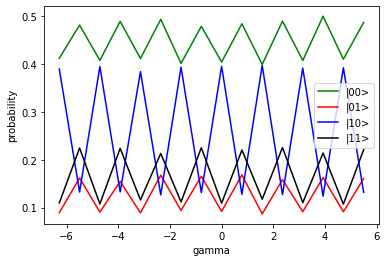

In [ ]:
plt.plot(gamma,state3_00,color='g',label='|00>')
plt.plot(gamma,state3_01, color='r',label='|01>')
plt.plot(gamma,state3_10,color='b',label='|10>')
plt.plot(gamma,state3_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('probability')

#### Four Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 4
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ']
state4_00 = []
state4_01 = []
state4_10 = []
state4_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  state4_00.append(State[0])
  state4_01.append(State[1])
  state4_10.append(State[2])
  state4_11.append(State[3])

Text(0, 0.5, 'probability')

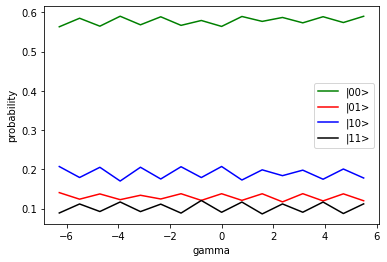

In [ ]:
plt.plot(gamma,state4_00,color='g',label='|00>')
plt.plot(gamma,state4_01, color='r',label='|01>')
plt.plot(gamma,state4_10,color='b',label='|10>')
plt.plot(gamma,state4_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('probability')

#### Five Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 5
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ']
state5_00 = []
state5_01 = []
state5_10 = []
state5_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  state5_00.append(State[0])
  state5_01.append(State[1])
  state5_10.append(State[2])
  state5_11.append(State[3])

Text(0, 0.5, 'probability')

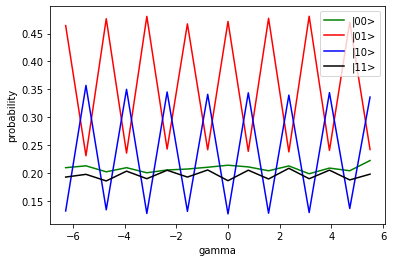

In [ ]:
plt.plot(gamma,state5_00,color='g',label='|00>')
plt.plot(gamma,state5_01, color='r',label='|01>')
plt.plot(gamma,state5_10,color='b',label='|10>')
plt.plot(gamma,state5_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('probability')

#### Combining Trotter Steps

In [ ]:
trotterstep = np.array([1,2,3,4,5])
trot00 = np.array([np.mean(state_00),np.mean(state2_00),np.mean(state3_00),np.mean(state4_00),np.mean(state5_00)])
trot01 = np.array([np.mean(state_01),np.mean(state2_01),np.mean(state3_01),np.mean(state4_01),np.mean(state5_01)])
trot10 = np.array([np.mean(state_10),np.mean(state2_10),np.mean(state3_10),np.mean(state4_10),np.mean(state5_10)])
trot11 = np.array([np.mean(state_11),np.mean(state2_11),np.mean(state3_11),np.mean(state4_11),np.mean(state5_11)])
trot00_std = np.array([np.std(state_00),np.std(state2_00),np.std(state3_00),np.std(state4_00),np.std(state5_00)])
trot01_std = np.array([np.std(state_01),np.std(state2_01),np.std(state3_01),np.std(state4_01),np.std(state5_01)])
trot10_std = np.array([np.std(state_10),np.std(state2_10),np.std(state3_10),np.std(state4_10),np.std(state5_10)])
trot11_std = np.array([np.std(state_11),np.std(state_11),np.std(state3_11),np.std(state4_11),np.std(state5_11)])

Text(0, 0.5, 'probability')

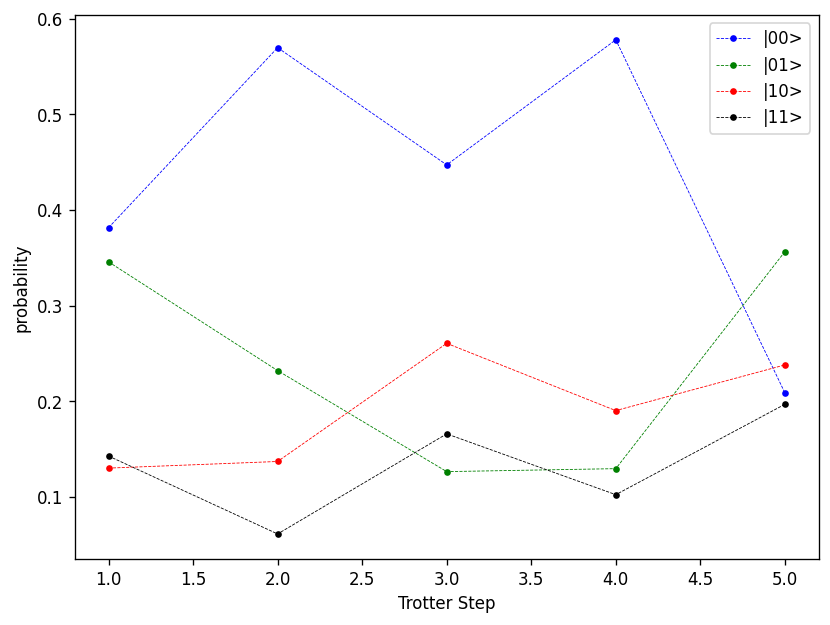

In [ ]:
figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(trotterstep,trot00,'b.--',linewidth=0.5,label='|00>')
plt.plot(trotterstep,trot01,'g.--',linewidth=0.5,label='|01>')
plt.plot(trotterstep,trot10,'r.--',linewidth=0.5,label='|10>')
plt.plot(trotterstep,trot11,'k.--',linewidth=0.5,label='|11>')
plt.legend()
plt.xlabel('Trotter Step')
plt.ylabel('probability')

### XX+YY+ZZ Basis

#### Single Trotter Step

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 1
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ','XX','YY']
XYZ_state1_00 = []
XYZ_state1_01 = []
XYZ_state1_10 = []
XYZ_state1_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  XYZ_state1_00.append(np.sum(State[0]))
  XYZ_state1_01.append(np.sum(State[1]))
  XYZ_state1_10.append(np.sum(State[2]))
  XYZ_state1_11.append(np.sum(State[3]))

Text(0, 0.5, 'Sum of XX YY ZZ Prob')

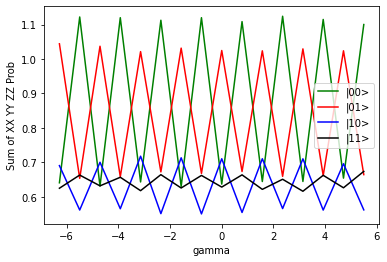

In [ ]:
plt.plot(gamma,XYZ_state1_00,color='g',label='|00>')
plt.plot(gamma,XYZ_state1_01, color='r',label='|01>')
plt.plot(gamma,XYZ_state1_10,color='b',label='|10>')
plt.plot(gamma,XYZ_state1_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Sum of XX YY ZZ Prob')

#### Two Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 2
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ','XX','YY']
XYZ_state2_00 = []
XYZ_state2_01 = []
XYZ_state2_10 = []
XYZ_state2_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  XYZ_state2_00.append(np.sum(State[0]))
  XYZ_state2_01.append(np.sum(State[1]))
  XYZ_state2_10.append(np.sum(State[2]))
  XYZ_state2_11.append(np.sum(State[3]))

Text(0, 0.5, 'Sum of XX YY ZZ Prob')

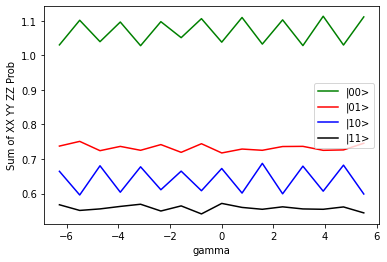

In [ ]:
plt.plot(gamma,XYZ_state2_00,color='g',label='|00>')
plt.plot(gamma,XYZ_state2_01, color='r',label='|01>')
plt.plot(gamma,XYZ_state2_10,color='b',label='|10>')
plt.plot(gamma,XYZ_state2_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Sum of XX YY ZZ Prob')

#### Three Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 3
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ','XX','YY']
XYZ_state3_00 = []
XYZ_state3_01 = []
XYZ_state3_10 = []
XYZ_state3_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  XYZ_state3_00.append(np.sum(State[0]))
  XYZ_state3_01.append(np.sum(State[1]))
  XYZ_state3_10.append(np.sum(State[2]))
  XYZ_state3_11.append(np.sum(State[3]))

Text(0, 0.5, 'Sum of XX YY ZZ Prob')

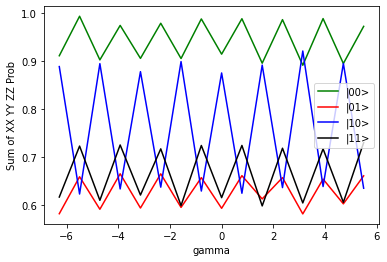

In [ ]:
plt.plot(gamma,XYZ_state3_00,color='g',label='|00>')
plt.plot(gamma,XYZ_state3_01, color='r',label='|01>')
plt.plot(gamma,XYZ_state3_10,color='b',label='|10>')
plt.plot(gamma,XYZ_state3_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Sum of XX YY ZZ Prob')

#### Four Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 4
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ','XX','YY']
XYZ_state4_00 = []
XYZ_state4_01 = []
XYZ_state4_10 = []
XYZ_state4_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  XYZ_state4_00.append(np.sum(State[0]))
  XYZ_state4_01.append(np.sum(State[1]))
  XYZ_state4_10.append(np.sum(State[2]))
  XYZ_state4_11.append(np.sum(State[3]))

Text(0, 0.5, 'Sum of XX YY ZZ Prob')

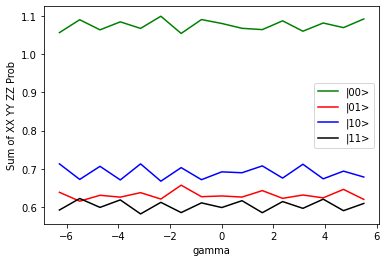

In [ ]:
plt.plot(gamma,XYZ_state4_00,color='g',label='|00>')
plt.plot(gamma,XYZ_state4_01, color='r',label='|01>')
plt.plot(gamma,XYZ_state4_10,color='b',label='|10>')
plt.plot(gamma,XYZ_state4_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Sum of XX YY ZZ Prob')

#### Five Trotter Steps

In [ ]:
shots= 10000
qbit = 6
cbit = 2
trotter = 5
gamma = np.arange(-2*pi,2*pi,pi/4)
basis = ['ZZ','XX','YY']
XYZ_state5_00 = []
XYZ_state5_01 = []
XYZ_state5_10 = []
XYZ_state5_11 = []
for i in tqdm(range(len(gamma))):
  var = np.array([pi/12,pi/12,gamma[i]])
  State = Results('odd',qbit,cbit,trotter,basis,var,shots)
  XYZ_state5_00.append(np.sum(State[0]))
  XYZ_state5_01.append(np.sum(State[1]))
  XYZ_state5_10.append(np.sum(State[2]))
  XYZ_state5_11.append(np.sum(State[3]))

Text(0, 0.5, 'Sum of XX YY ZZ Prob')

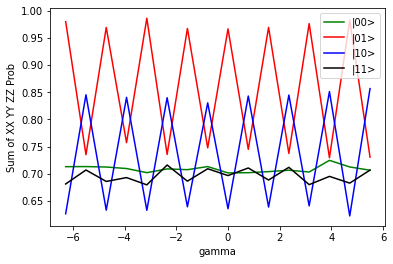

In [ ]:
plt.plot(gamma,XYZ_state5_00,color='g',label='|00>')
plt.plot(gamma,XYZ_state5_01, color='r',label='|01>')
plt.plot(gamma,XYZ_state5_10,color='b',label='|10>')
plt.plot(gamma,XYZ_state5_11,color='k',label='|11>')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('Sum of XX YY ZZ Prob')

#### Combining Trotter Steps

In [ ]:
XYZ_trotterstep = np.array([1,2,3,4,5])
XYZ_trot00 = np.array([np.mean(XYZ_state1_00),np.mean(XYZ_state2_00),np.mean(XYZ_state3_00),np.mean(XYZ_state4_00),np.mean(XYZ_state5_00)])
XYZ_trot01 = np.array([np.mean(XYZ_state1_01),np.mean(XYZ_state2_01),np.mean(XYZ_state3_01),np.mean(XYZ_state4_01),np.mean(XYZ_state5_01)])
XYZ_trot10 = np.array([np.mean(XYZ_state1_10),np.mean(XYZ_state2_10),np.mean(XYZ_state3_10),np.mean(XYZ_state4_10),np.mean(XYZ_state5_10)])
XYZ_trot11 = np.array([np.mean(XYZ_state1_11),np.mean(XYZ_state2_11),np.mean(XYZ_state3_11),np.mean(XYZ_state4_11),np.mean(XYZ_state5_11)])
XYZ_trot00_std = np.array([np.std(XYZ_state1_00),np.std(XYZ_state2_00),np.std(XYZ_state3_00),np.std(XYZ_state4_00),np.std(XYZ_state5_00)])
XYZ_trot01_std = np.array([np.std(XYZ_state1_01),np.std(XYZ_state2_01),np.std(XYZ_state3_01),np.std(XYZ_state4_01),np.std(XYZ_state5_01)])
XYZ_trot10_std = np.array([np.std(XYZ_state1_10),np.std(XYZ_state2_10),np.std(XYZ_state3_10),np.std(XYZ_state4_10),np.std(XYZ_state5_10)])
XYZ_trot11_std = np.array([np.std(XYZ_state1_11),np.std(XYZ_state2_11),np.std(XYZ_state3_11),np.std(XYZ_state4_11),np.std(XYZ_state5_11)])

Text(0, 0.5, 'Sum of XX YY ZZ Prob')

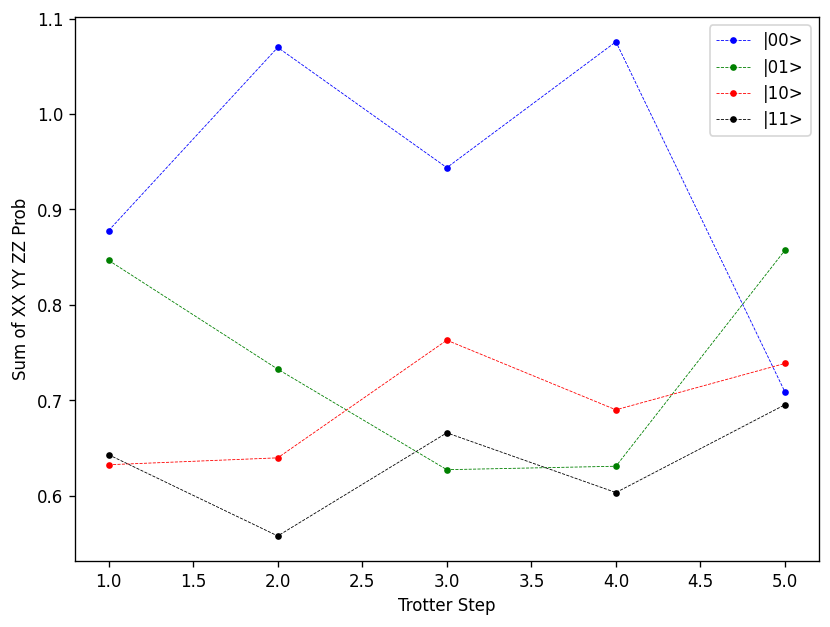

In [ ]:
figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(XYZ_trotterstep,XYZ_trot00,'b.--',linewidth=0.5,label='|00>')
plt.plot(XYZ_trotterstep,XYZ_trot01,'g.--',linewidth=0.5,label='|01>')
plt.plot(XYZ_trotterstep,XYZ_trot10,'r.--',linewidth=0.5,label='|10>')
plt.plot(XYZ_trotterstep,XYZ_trot11,'k.--',linewidth=0.5,label='|11>')
plt.legend()
plt.xlabel('Trotter Step')
plt.ylabel('Sum of XX YY ZZ Prob')